# TOP

In [1]:
import functools
import itertools
import pickle

import cmocean.cm as cmo
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import polars as pl
import scipy.integrate as integrate
import scipy.optimize as optimize
import scipy.signal as signal
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import pickle
from tqdm.notebook import tqdm

from flexfrac1d.model.model import Ice, FloatingIce, Floe, Ocean, WavesUnderFloe, WavesUnderIce
from flexfrac1d.model.model import DiscreteSpectrum, WavesUnderElasticPlate


# \textwidth := 177 mm approx 6.97 in
# \columnsep := 7 mm approx -> \colwidth approx 3.35 in
WIDTH_TWO_COLUMNS = 3.0
WIDTH_SINGLE_COLUMN = 6.3
GR = (1 + 5**.5) / 2

from lib.lib import (
    make_parameters,
    compute_split,
    compute_dissipation_length,
    threshold_search,
    calc_energy_if_frac,
    colours
)

palette = sns.color_palette(colours)

In [3]:
gravity = 9.8
thickness = .01
depth = .45 - .9 * thickness
periods = .8, 1, 1.2
idx = 0
for idx in range(3):
    wuep = WavesUnderElasticPlate.from_ocean(
        Ice(density=900, thickness=thickness, youngs_modulus=4e9),
        Ocean(density=1000, depth=depth),
        DiscreteSpectrum(frequencies=1/periods[idx], amplitudes=1),
        gravity=gravity,
    )
    print(wuep.ice.elastic_length * wuep.wavenumbers)

[1.17755294]
[1.04983058]
[0.9467326]


In [2]:
with open("res_baptiste/params_tot_AUVITY.pkl", "rb") as f:
    pickled_dict = pickle.load(f)

data_x = pickled_dict["lambda_s"]  # 2 * np.pi / pickled_dict["k_s"]
sk = np.argsort(data_x)
data_x = data_x[sk]
data_y = pickled_dict["a_s"][sk]
fit_data = sm.OLS(data_y, sm.add_constant(data_x)).fit()
fit_data_log = sm.OLS(np.log10(data_y), sm.add_constant(np.log10(data_x))).fit()

print(pickled_dict.keys())

experimental_wavelengths = pickled_dict["lambda_s"]
experimental_thresholds = pickled_dict["a_s"]
experimental_wavenumbers = 2 * np.pi / experimental_wavelengths
experimental_flex_lengths = pickled_dict["L_d"]
exp_nondim = experimental_wavenumbers * experimental_flex_lengths
experimental_thicknesses = pickled_dict["h"]
_hmean = np.mean((
    1.58392329e-04, 1.22305404e-04, 1.01675285e-04, 8.78396242e-05,
    1.13577006e-04, 9.65212350e-05, 8.68343850e-05, 9.93907358e-05,
    1.05360029e-04, 7.81676244e-05, 8.16568323e-05, 9.36568645e-05,
    1.01332822e-04, 2.07284529e-04, 6.62850904e-05, 6.36798316e-05,
    5.74934571e-05, 1.84573154e-04, 1.14202478e-04,
))

_temp_wl, _temp_kappa_c = np.loadtxt("res_baptiste/kappa_c.txt", usecols=range(1, 11))
assert np.allclose(experimental_wavelengths - _temp_wl, 0)
experimental_curvature_thresholds = _temp_kappa_c

exp_y_mean = experimental_curvature_thresholds**2 * pickled_dict["l_s"] * _hmean
exp_y = experimental_curvature_thresholds**2 * pickled_dict["l_s"] * experimental_thicknesses

dict_keys(['L_d', 'D', 'l_s', 'a_s', 'k_s', 'h', 'lambda_s', 'l_crack', 'dates', 'path', 'nom_exps', 'rho'])


# Dataframe

In [3]:
gravity, tank_params, varnish_params = make_parameters()

varnish = Ice(**varnish_params)
tank = Ocean(**tank_params)
floating_varnish = FloatingIce.from_ice_ocean(ice=varnish, ocean=tank, gravity=gravity)
flexural_length = floating_varnish.elastic_length

harmonic_number = 3
if harmonic_number == 3:
    path = "results/stationnary_ensemble_comparison_nondim.npz"
elif harmonic_number in (1, 2, 4):
    path = f"results/stationnary_ensemble_comparison_nondim_hn{harmonic_number:02d}.npz"
else:
    raise ValueError
    
loaded = np.load(path)
(
    nondim,
    thicknesses,
    youngs_moduli,
    flexural_rigidities,
    flex_lengths,
    lengths,
    energy_release_rates,
    wavenumbers,
    amplitude_thresholds,
    curvature_thresholds,
    energy_dissipation_lengths,
) = (
    loaded[k] for k in (
        "nondim",
        "thicknesses",
        "youngs_moduli",
        "flexural_rigidities",
        "flex_lengths",
        "lengths",
        "energy_release_rates",
        "wavenumbers",
        "amplitude_thresholds",
        "curvature_thresholds",
        "energy_dissipation_lengths",
    )
)
n_samples = len(thicknesses)

ensemble_results = pl.from_dict(
    dict(
        nondim=np.tile(nondim, n_samples),
        thickness=np.repeat(thicknesses, nondim.size),
        youngs_modulus=np.repeat(youngs_moduli, nondim.size),
        flexural_rigidity=np.repeat(flexural_rigidities, nondim.size),
        flexural_length=np.repeat(flex_lengths, nondim.size),
        energy_release_rate=np.repeat(energy_release_rates, nondim.size),
        amplitude_threshold=np.ravel(amplitude_thresholds),
        curvature_threshold=np.ravel(curvature_thresholds),
        energy_dissipation_length=np.ravel(energy_dissipation_lengths),
    )
)
ensemble_results = ensemble_results.with_columns(
    (pl.col("nondim") / pl.col("flexural_length")).alias("wavenumber"),
    pl.col("curvature_threshold").abs(),
).with_columns(
    (pl.col("curvature_threshold") * pl.col("thickness") / 2).alias("strain_threshold"),
    (
        pl.col("curvature_threshold")**2
        * pl.col("energy_dissipation_length")
        * pl.col("thickness")
    ).alias("constant1"),
    (
        2
        * pl.col("energy_release_rate")
        * pl.col("thickness")**2
        / pl.col("flexural_rigidity")
    ).alias("constant2"),  # this one should be constant by definition
    (pl.col("energy_dissipation_length") / (2**.5 * pl.col("flexural_length"))).alias("normalised_dis_length"),
).with_columns(
    (pl.col("constant1") * pl.col("thickness")).alias("constant_length")
)

In [25]:
np.savez(
    "thickness_modulus_ensemble.npz",
    thicknesses=thicknesses,
    youngs_moduli=youngs_moduli
)

# Figures

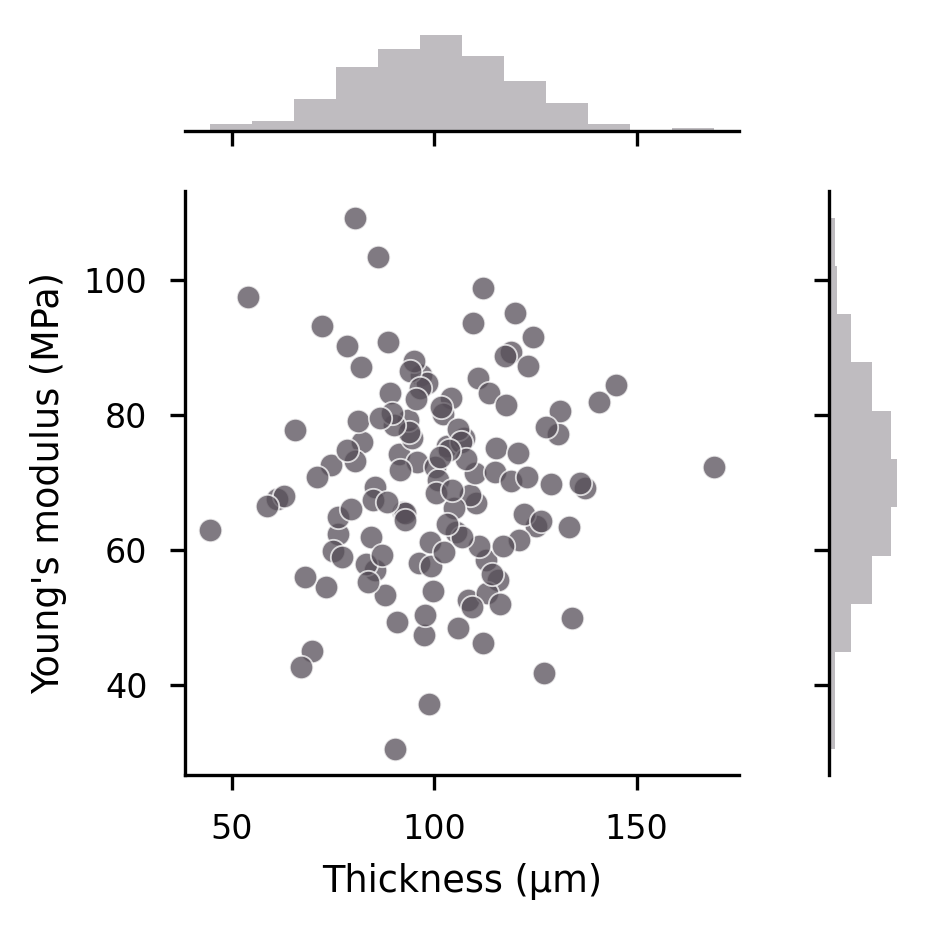

In [4]:
with plt.style.context("seaborn-v0_8-paper"):
    g = sns.JointGrid(
        **dict(zip(("x", "y"), (thicknesses * 1e6, youngs_moduli / 1e6)), height=3.2, ratio=4)
    )
    fig = g.figure
    fig.set_dpi(300)
    g.plot_joint(sns.scatterplot, c=colours[3], alpha=.75)
    g.plot_marginals(sns.histplot, edgecolor=None, facecolor=f"{colours[3]}60")
    g.set_axis_labels("Thickness (µm)", "Young's modulus (MPa)")
    # fig.axes[0].scatter(pickled_dict["h"] * 1e6, (pickled_dict["D"] * 12 * (1 - poissons_ratio**2) / pickled_dict["h"]**3) / 1e6)
    fig.tight_layout()
    # fig.savefig("joint_density.pdf", dpi=fig.dpi, bbox_inches="tight")
    plt.show()
    plt.close()

## Amplitude

In [5]:
corrected_amplitudes = (experimental_curvature_thresholds
    * (1 + (experimental_wavenumbers * experimental_flex_lengths)**4)
    / experimental_wavenumbers**2
)
# corrected_amplitudes2 = (
#     experimental_curvature_thresholds
#     / experimental_wavenumbers**2
# )

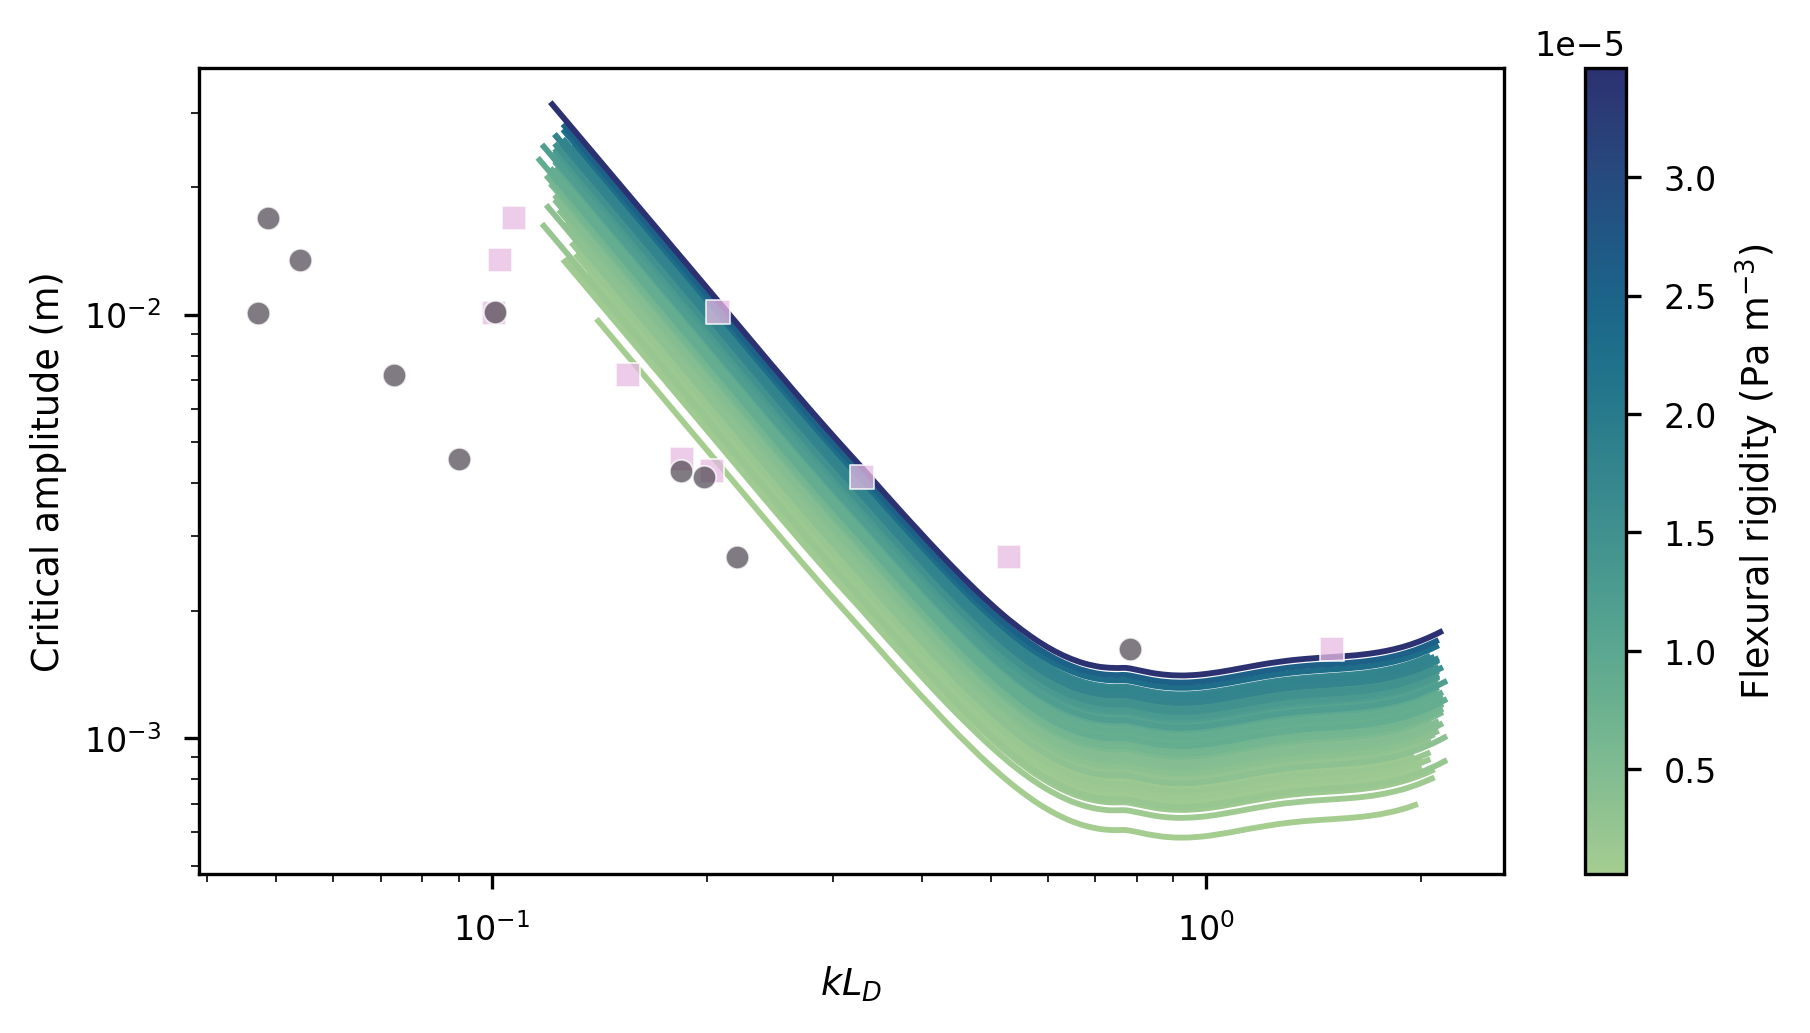

In [6]:
hue = "flexural_rigidity"
width = WIDTH_SINGLE_COLUMN
height = width / GR / 1.098

with plt.style.context("seaborn-v0_8-paper"), palette:
    fig, ax = plt.subplots(dpi=300, figsize=(width, height))
    
    sns.lineplot(
        ensemble_results,
        x="nondim",
        y="amplitude_threshold",
        ax=ax,
        hue=hue,
        palette="crest",
        legend="full",
    )
    sns.scatterplot(
        x=experimental_wavenumbers * experimental_flex_lengths,
        y=experimental_thresholds,
        ax=ax,
        color="C3",
        zorder=10,
        alpha=.75,
        label="Physical experiment"
    )
    sns.scatterplot(
        x=experimental_flex_lengths / pickled_dict["l_s"],
        y=experimental_thresholds,
        ax=ax,
        color="C4",
        marker="s",
        alpha=.75,
        zorder=8,
        label="Physical experiment"
    )
    ax.set_xlabel("$k L_D$")
    ax.set_ylabel("Critical amplitude (m)")
    ax.loglog()

    ax.get_legend().set_visible(False)
    
    vmin, vmax = np.sort(
        (ensemble_results.select(hue).unique().to_numpy()[:, 0])
    )[[0, -1]]
    cbar = fig.colorbar(
        mpl.cm.ScalarMappable(
            norm=mpl.colors.Normalize(
                vmin=vmin,
                vmax=vmax,
                clip=False
            ),
            cmap="crest"
        ),
        ax=ax,
        label="Flexural rigidity (Pa m$^{-3}$)",
    )

    fig.tight_layout()

    # fig.savefig("ensemble_amplitude.pdf", dpi=fig.dpi, bbox_inches="tight")
    
    plt.show()
    plt.close()

In [14]:
ensemble_results.write_csv("ensemble.csv")

In [15]:
np.savez(
    "experimental.npz",
    wavenumbers=experimental_wavenumbers,
    flex_lengths=experimental_flex_lengths,
    critical_amplitudes=experimental_thresholds,
    fwhm=pickled_dict["l_s"],
)

[1.6189639162758465]


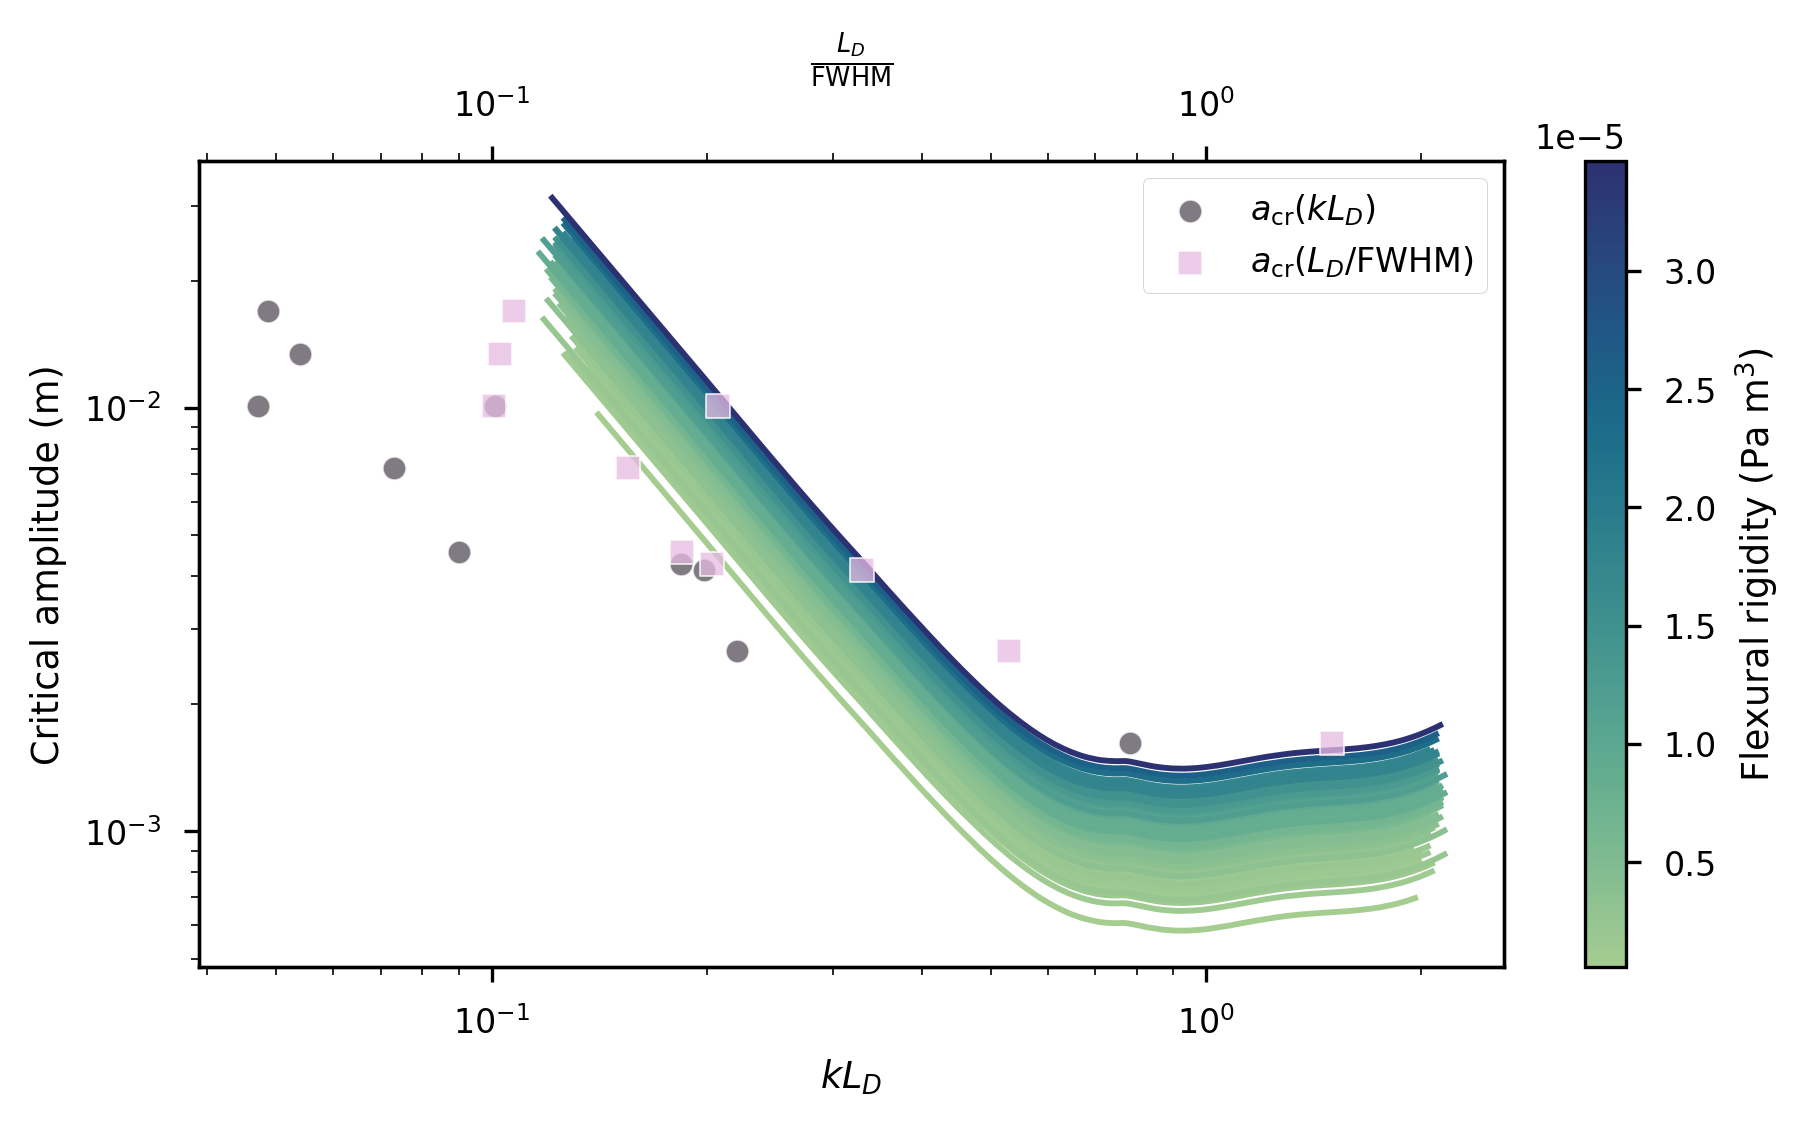

In [11]:
hue = "flexural_rigidity"
width = WIDTH_SINGLE_COLUMN
height = width / GR / 1.01

with plt.style.context("seaborn-v0_8-paper"), palette:
    fig, ax = plt.subplots(dpi=300, figsize=(width, height))
    
    axt = ax.twiny()
    axt.sharex(ax)
    
    sns.lineplot(
        ensemble_results,
        x="nondim",
        y="amplitude_threshold",
        ax=ax,
        hue=hue,
        palette="crest",
        legend="full",
    )
    sns.scatterplot(
        x=experimental_wavenumbers * experimental_flex_lengths,
        y=experimental_thresholds,
        ax=ax,
        color="C3",
        zorder=10,
        alpha=.75,
        label=r"$a_\mathrm{cr}(kL_D)$"
    )
    sns.scatterplot(
        x=experimental_flex_lengths / pickled_dict["l_s"],
        y=experimental_thresholds,
        ax=axt,
        color="C4",
        marker="s",
        alpha=.75,
        zorder=8,
        label=r"$a_\mathrm{cr}(L_D / \mathrm{FWHM})$"
    )
    
    ax.set_xlabel("$k L_D$")
    axt.set_xlabel(r"$\frac{L_D}{\mathrm{FWHM}}$")
    ax.set_ylabel("Critical amplitude (m)")
    ax.loglog()
    # ax.set_xscale("log")

    ax.get_legend().set_visible(False)
    axt.get_legend().set_visible(False)

    handles, labels = zip(
        list(zip(*ax.get_legend_handles_labels()))[-1],
        next(zip(*axt.get_legend_handles_labels()))
    )
    ax.legend(handles, labels)
    # handles, labels = ax.get_legend_handles_labels()
    # ax.legend(handles[-2:], labels[-2:])

    # x0, y0 = 1e-1, 6e-3
    # x0, y0 = exp_nondim[2], corrected_amplitudes[2]
    # powow = -2
    # x1 = 2 * x0
    # y1 = y0 * (x1 / x0)**powow
    # ax.axline((x0, y0), (x1, y1), ls="--", c="C3")
    
    vmin, vmax = np.sort(
        (ensemble_results.select(hue).unique().to_numpy()[:, 0])
    )[[0, -1]]
    cbar = fig.colorbar(
        mpl.cm.ScalarMappable(
            norm=mpl.colors.Normalize(
                vmin=vmin,
                vmax=vmax,
                clip=False
            ),
            cmap="crest"
        ),
        ax=axt,
        # label="Energy release rate (J m$^{-2}$)",
        # label="Flexural length (m)",
        label="Flexural rigidity (Pa m$^{3}$)",
    )

    fig.tight_layout()
    print([ax.bbox.width / ax.bbox.height])

    # fig.savefig("ensemble_amplitude.pdf", dpi=fig.dpi, bbox_inches="tight")
    
    plt.show()
    plt.close()

[1.5441343562516494]


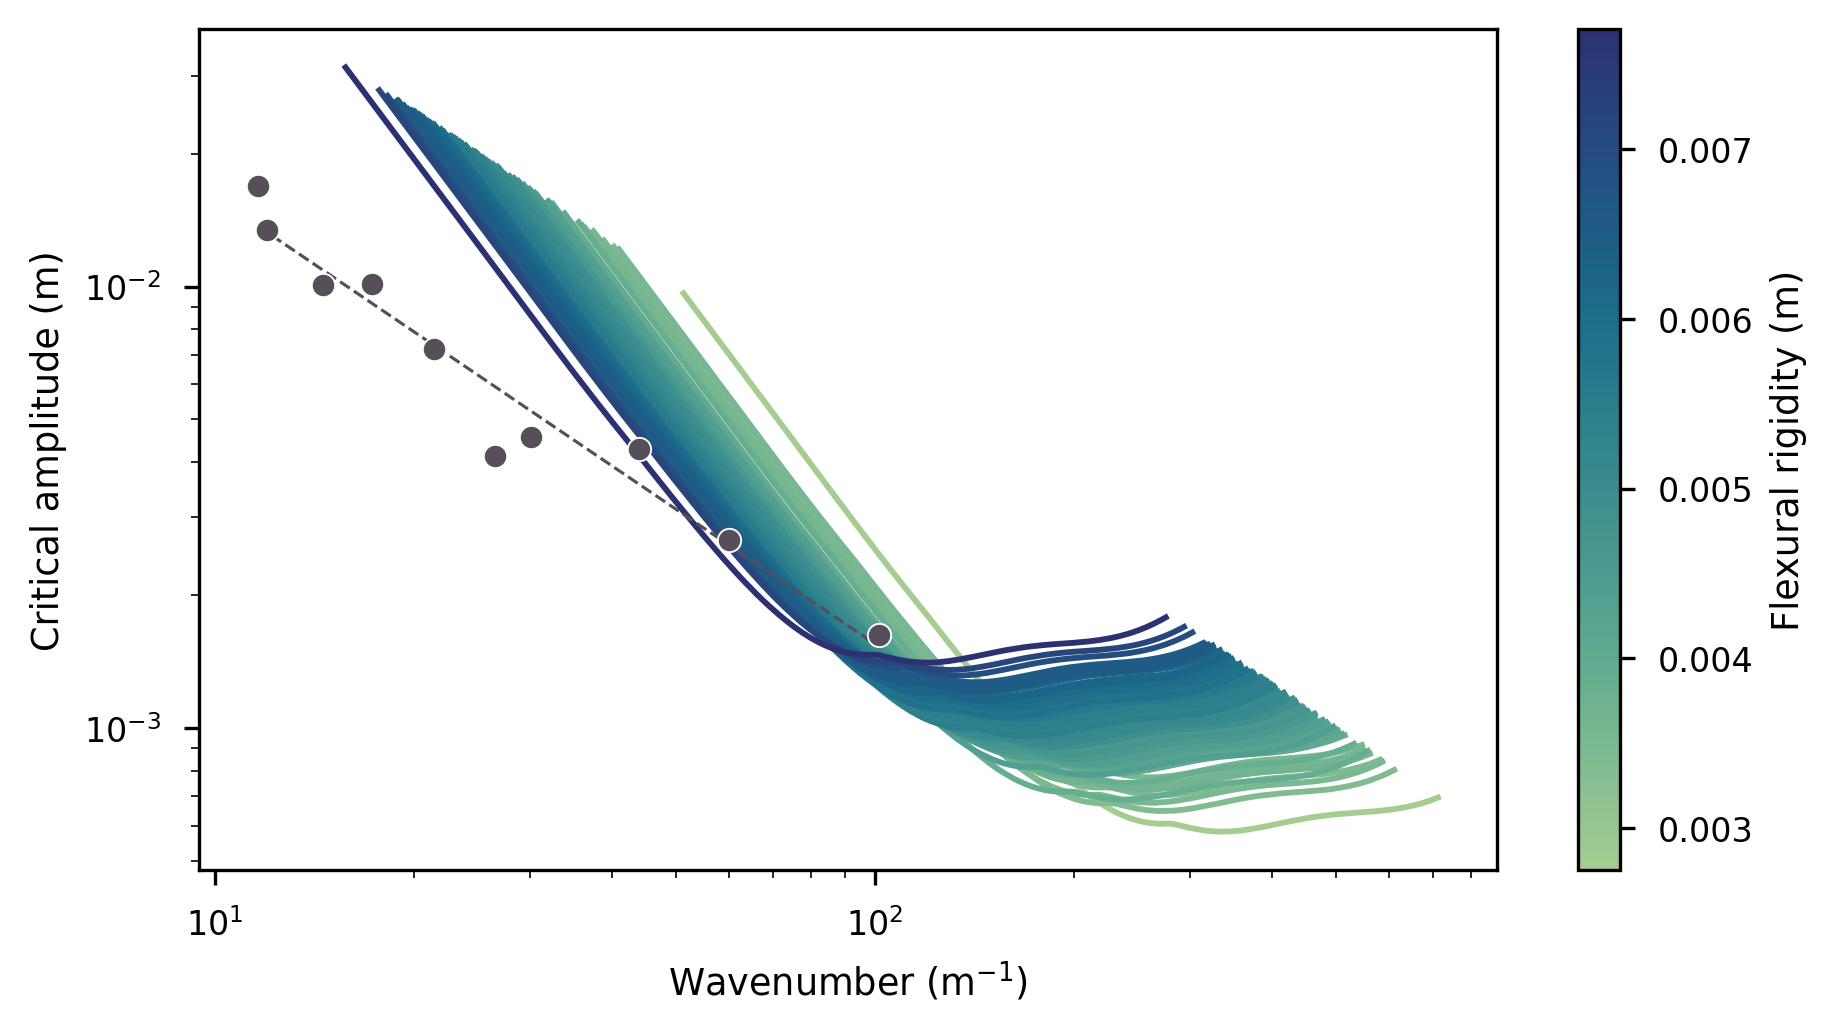

In [527]:
# fit = sm.OLS(np.log(experimental_thresholds), sm.add_constant(np.log(experimental_wavenumbers))).fit()

hue = "flexural_length"
width = WIDTH_SINGLE_COLUMN
height = width / GR / 1.098

with plt.style.context("seaborn-v0_8-paper"), palette:
    fig, ax = plt.subplots(dpi=300, figsize=(width, height))
    
    sns.lineplot(
        ensemble_results,
        x="wavenumber",
        y="amplitude_threshold",
        ax=ax,
        hue=hue,
        palette="crest",
        legend="full",
    )
    sns.scatterplot(
        x=xx,
        y=yy,
        ax=ax,
        color="C3",
        zorder=10,
        label="Physical experiment"
    )
    ax.plot(
        xx, np.exp(fit.fittedvalues), "C3",
        ls="--",
        lw=.75,
    )
    # ax.fill_between(
    #     xx, np.exp(fit.fittedvalues - pred.se_mean),
    #     np.exp(fit.fittedvalues + pred.se_mean), alpha=.2, color="C3"
    # )
    
    ax.set_xlabel("Wavenumber (m$^{-1}$)")
    ax.set_ylabel("Critical amplitude (m)")
    ax.loglog()

    ax.get_legend().set_visible(False)
    
    vmin, vmax = np.sort(
        (ensemble_results.select(hue).unique().to_numpy()[:, 0])
    )[[0, -1]]
    cbar = fig.colorbar(
        mpl.cm.ScalarMappable(
            norm=mpl.colors.Normalize(
                vmin=vmin,
                vmax=vmax,
                clip=False
            ),
            cmap="crest"
        ),
        ax=ax,
        label="Flexural length (m)",
    )

    fig.tight_layout()
    print([ax.bbox.width / ax.bbox.height])

    # fig.savefig("ensemble_amplitude.pdf", dpi=fig.dpi, bbox_inches="tight")
    
    plt.show()
    plt.close()

0.20031647047498405
0.39873711638029535
0.8044866193163269
1.601359458820857


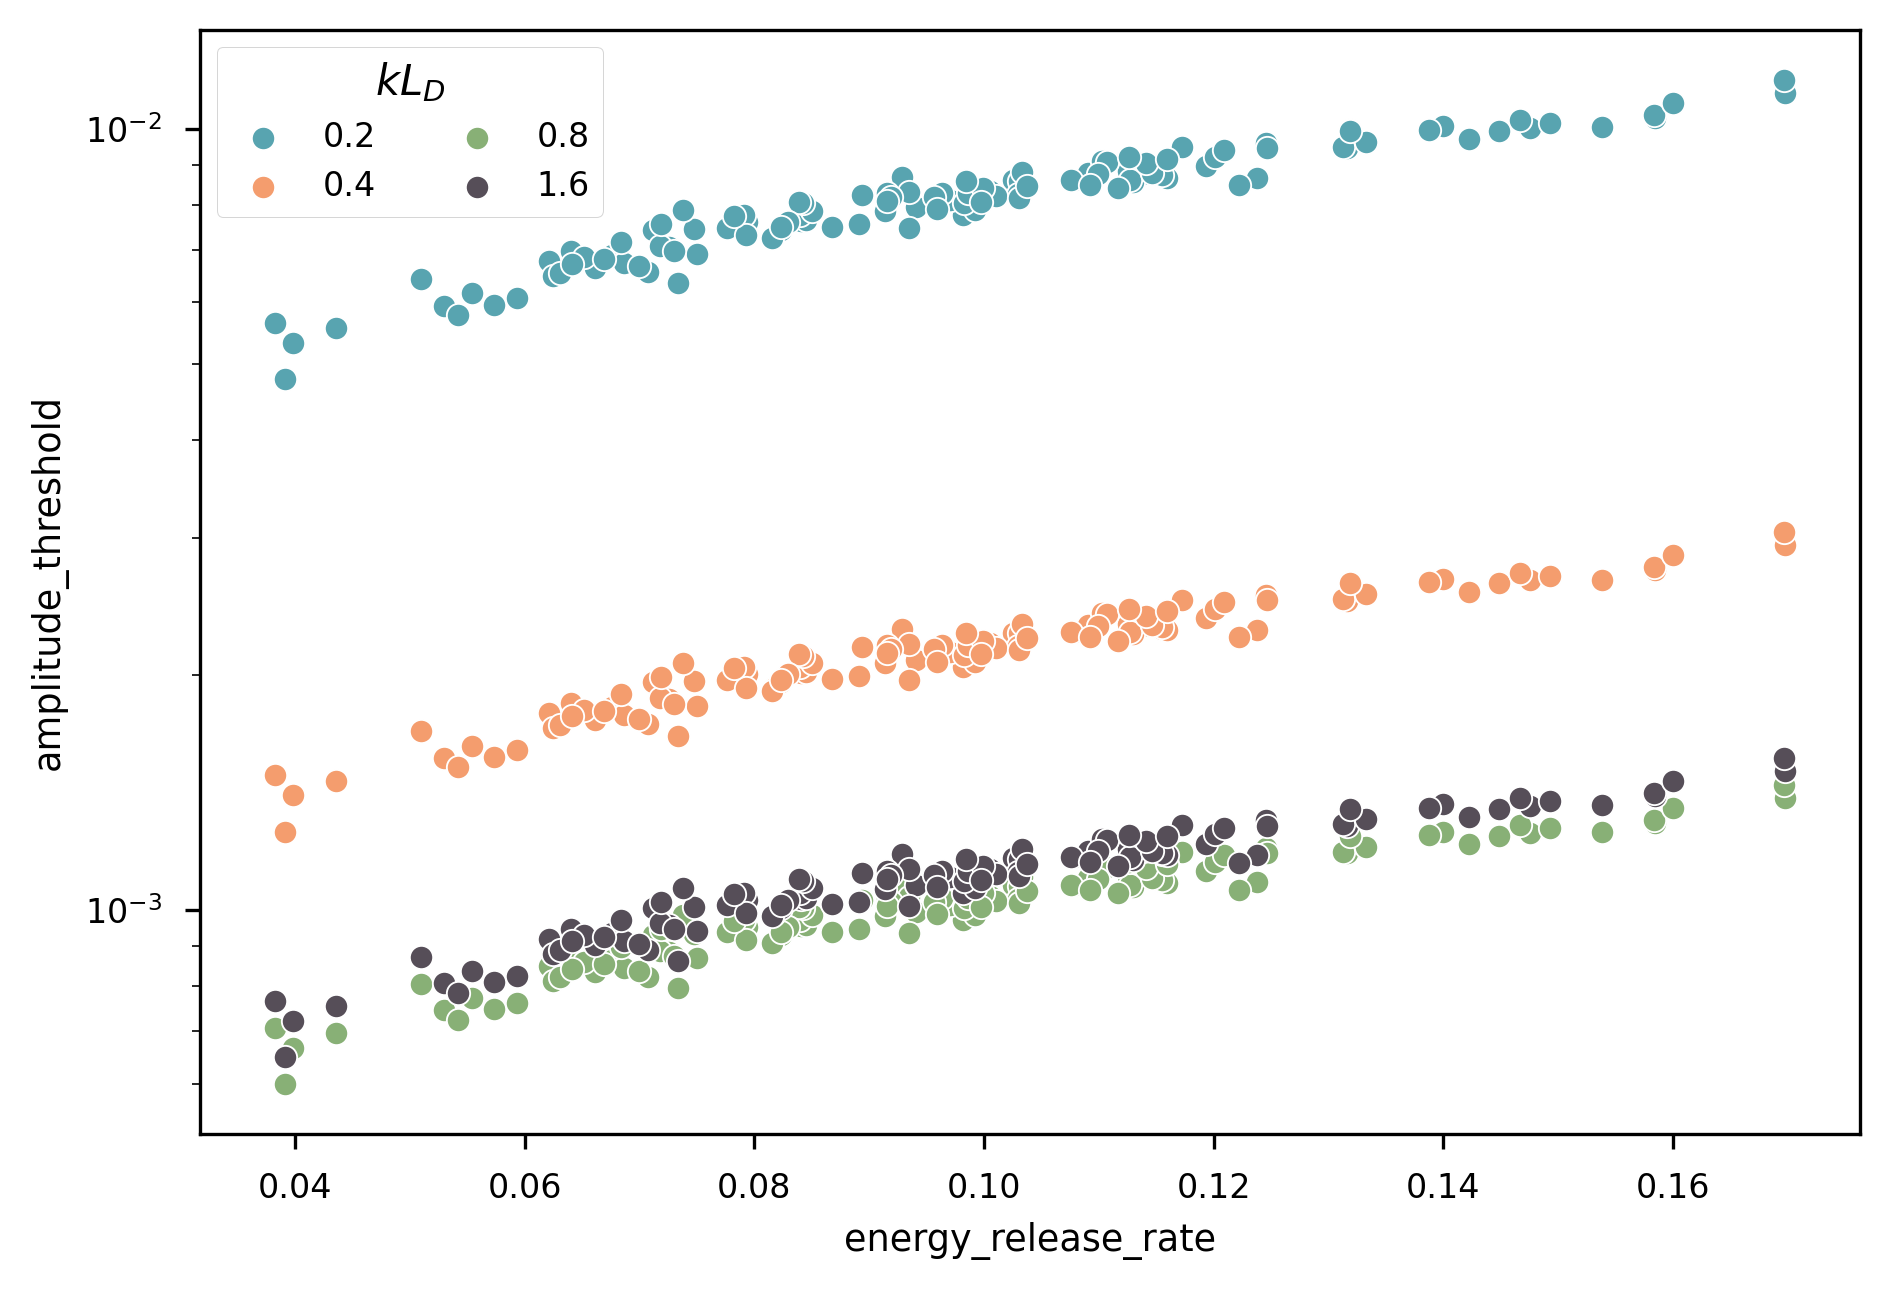

In [59]:
with plt.style.context("seaborn-v0_8-paper"), palette:
    fig, ax = plt.subplots(dpi=300)
    
    for target in (.2, .4, .8, 1.6):
        # target = 1
        arr = np.sort(
            ensemble_results.filter(~pl.col("amplitude_threshold").is_nan()).select("nondim").unique().to_numpy()[:, 0]
        )
        val = arr[np.argmin(np.abs(arr - target))]
        print(val)
        
        sns.scatterplot(
            ensemble_results.filter(pl.col("nondim") == val).with_columns(
                pl.col("amplitude_threshold")# / pl.col("amplitude_threshold").min()
            ),
            x="energy_release_rate",
            y="amplitude_threshold",
            ax=ax,
            label=target,
            # alpha=.25,
            # hue=hue,
            # palette="crest",
            # legend="full",
        )
        # ax.set_xscale("log")
        ax.set_yscale("log")
        ax.legend(title="$k L_D$", ncols=2)
        # ax.loglog()
    fig.tight_layout()
    fig.savefig("ensemble_amplitude_constant_nondim.pdf", dpi=fig.dpi, bbox_inches="tight")
    plt.show()
    plt.close()

[-1.80617552 -1.01282813]
[ 0.38720233 -1.37488326]
[-6.78307928 -0.77820769]
[-6.48288335 -1.10974835]


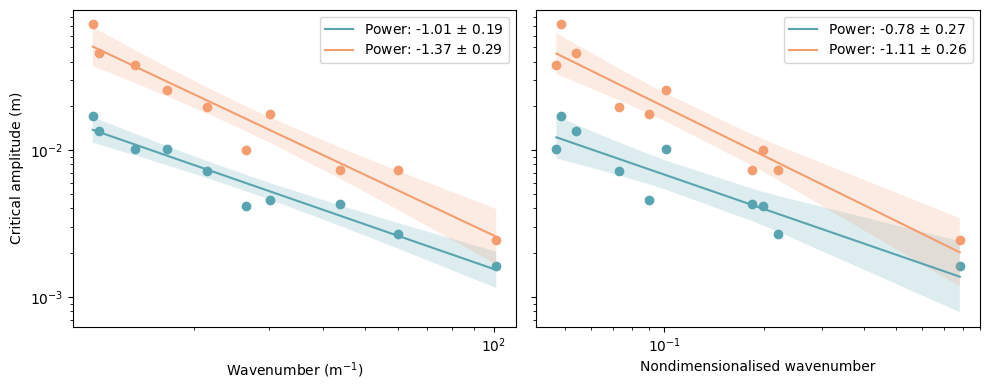

In [42]:
with palette:
    fig, axes = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
    
    for ax, xaxis in zip(axes, (experimental_wavenumbers, exp_nondim)):
        sk = np.argsort(xaxis)
        exog = sm.add_constant(np.log(xaxis[sk]))
    
        for i, yaxis in enumerate((experimental_thresholds, corrected_amplitudes)):
            endog = np.log(yaxis[sk])
            fit = sm.OLS(endog, exog).fit()
            print(fit.params)
            
            pred = fit.get_prediction(exog)
            pred_summary = pred.summary_frame(alpha=0.05)  # 95% confidence intervals
            
            # Extract confidence intervals
            ci_lower = pred_summary['mean_ci_lower']
            ci_upper = pred_summary['mean_ci_upper']
            
            ax.scatter(xaxis[sk], yaxis[sk], c=f"C{i}")
            ax.plot(
                xaxis[sk], np.exp(fit.fittedvalues), c=f"C{i}",
                label=rf"Power: {fit.params[1]:.2f} $\pm$ {fit.conf_int()[1, 1] - fit.params[1]:.2f}"
            )
            ax.fill_between(xaxis[sk], *np.exp((ci_lower, ci_upper)), facecolor=f"C{i}", alpha=.2)
        ax.loglog()
        ax.legend()
    axes[0].set_xlabel("Wavenumber (m$^{-1}$)")
    axes[0].set_ylabel("Critical amplitude (m)")
    axes[1].set_xlabel("Nondimensionalised wavenumber")
    
    fig.tight_layout()
    fig.savefig("experimental_power_fits.pdf", dpi=fig.dpi, bbox_inches="tight")
    plt.show()
    plt.close()

## Curvature

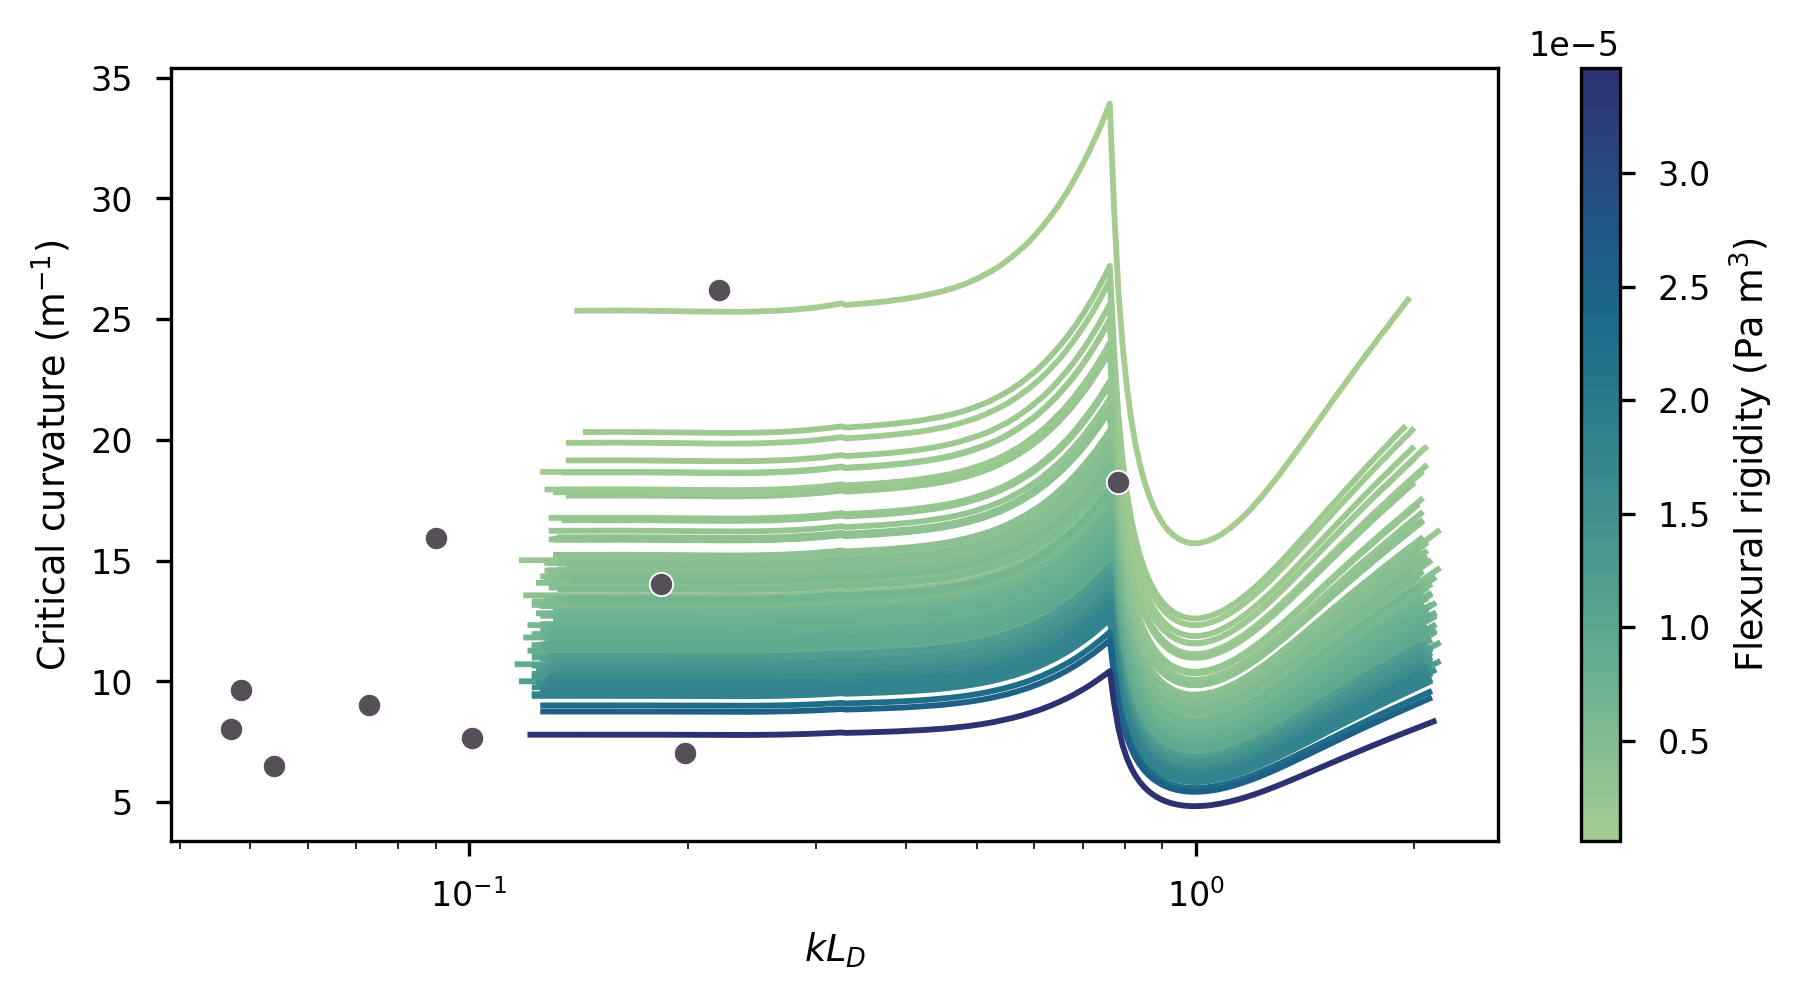

In [13]:
hue = "flexural_rigidity"
width = WIDTH_SINGLE_COLUMN
height = width / GR / 1.134

with plt.style.context("seaborn-v0_8-paper"), palette:
    fig, ax = plt.subplots(dpi=300, figsize=(width, height))
    
    sns.lineplot(
        ensemble_results,
        x="nondim",
        y="curvature_threshold",
        ax=ax,
        hue=hue,
        palette="crest",
        legend="full",
    )
    sns.scatterplot(
        x=exp_nondim,
        y=experimental_curvature_thresholds,
        ax=ax,
        color="C3",
        zorder=10,
        label="Physical experiment"
    )
    ax.set_xlabel("$k L_D$")
    ax.set_ylabel("Critical curvature (m$^{-1}$)")
    ax.set_xscale("log")

    ax.get_legend().set_visible(False)
    
    vmin, vmax = np.sort(
        (ensemble_results.select(hue).unique().to_numpy()[:, 0])
    )[[0, -1]]
    cbar = fig.colorbar(
        mpl.cm.ScalarMappable(
            norm=mpl.colors.Normalize(
                vmin=vmin,
                vmax=vmax,
                clip=False
            ),
            cmap="crest"
        ),
        ax=ax,
        label="Flexural rigidity (Pa m$^3$)"
        # label="Energy release rate (J m$^{-2}$)",
    )

    fig.tight_layout()

    # fig.savefig("ensemble_amplitude.pdf", dpi=fig.dpi, bbox_inches="tight")
    
    plt.show()
    plt.close()

## Strain

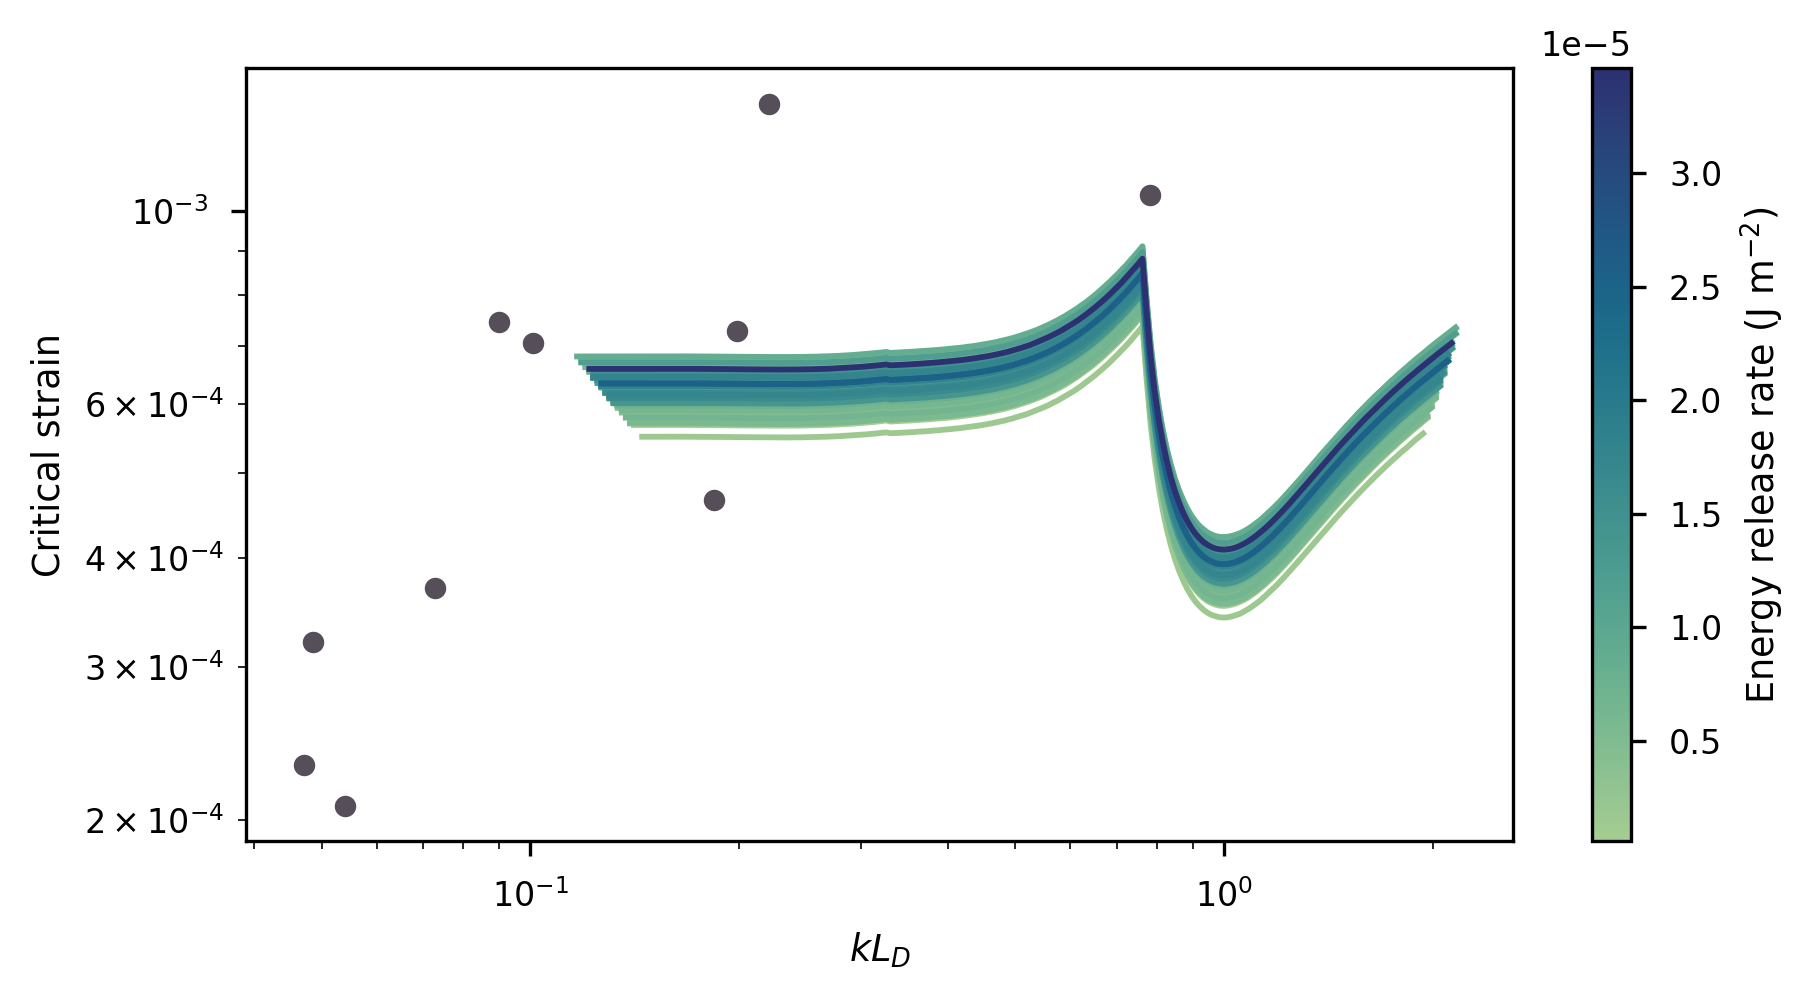

In [16]:
# hue = "energy_release_rate"
width = WIDTH_SINGLE_COLUMN
height = width / GR / 1.134

with plt.style.context("seaborn-v0_8-paper"), palette:
    fig, ax = plt.subplots(dpi=300, figsize=(width, height))
    
    sns.lineplot(
        ensemble_results,
        x="nondim",
        y="strain_threshold",
        ax=ax,
        hue="flexural_rigidity",
        palette="crest",
        legend="full",
    )
    sns.scatterplot(
        x=exp_nondim,
        y=experimental_curvature_thresholds * experimental_thicknesses / 2,
        ax=ax,
        color="C3",
        zorder=10,
        label="Physical experiment"
    )
    ax.set_xlabel("$k L_D$")
    ax.set_ylabel("Critical strain")
    ax.loglog()

    ax.get_legend().set_visible(False)
    
    vmin, vmax = np.sort(
        (ensemble_results.select(hue).unique().to_numpy()[:, 0])
    )[[0, -1]]
    cbar = fig.colorbar(
        mpl.cm.ScalarMappable(
            norm=mpl.colors.Normalize(
                vmin=vmin,
                vmax=vmax,
                clip=False
            ),
            cmap="crest"
        ),
        ax=ax,
        label="Energy release rate (J m$^{-2}$)",
    )

    fig.tight_layout()
    # fig.savefig("ensemble_curvature.pdf", dpi=fig.dpi, bbox_inches="tight")
    
    plt.show()
    plt.close()

## Relaxation length

[1.6691394423795065]


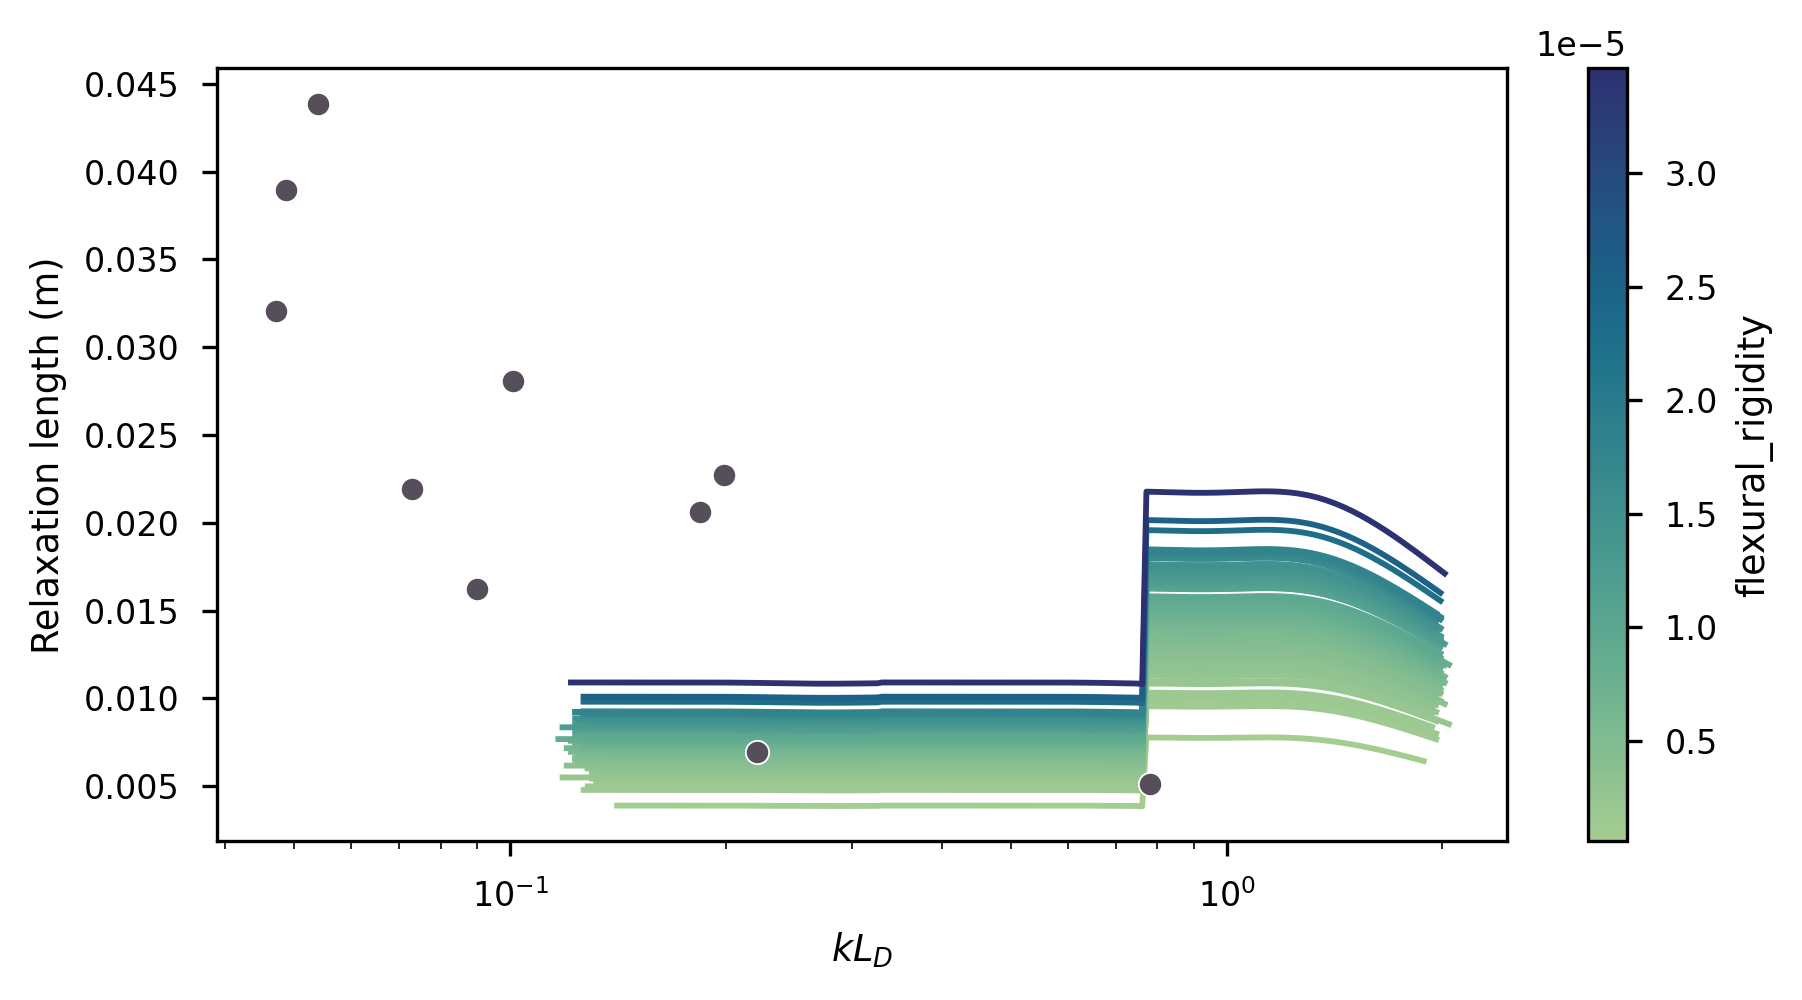

In [89]:
hue = "flexural_rigidity"
width = WIDTH_SINGLE_COLUMN
height = width / GR / 1.134

with plt.style.context("seaborn-v0_8-paper"), palette:
    fig, ax = plt.subplots(dpi=300, figsize=(width, height))
    
    sns.lineplot(
        ensemble_results,
        x="nondim",
        y="energy_dissipation_length",
        ax=ax,
        hue=hue,
        palette="crest",
        legend="full",
    )
    sns.scatterplot(
        x=exp_nondim,
        y=pickled_dict["l_s"],
        ax=ax,
        color="C3",
        zorder=10,
        label="Physical experiment"
    )
    ax.set_xlabel("$k L_D$")
    ax.set_ylabel("Relaxation length (m)")
    ax.set_xscale("log")

    ax.get_legend().set_visible(False)
    
    vmin, vmax = np.sort(
        (ensemble_results.select(hue).unique().to_numpy()[:, 0])
    )[[0, -1]]
    cbar = fig.colorbar(
        mpl.cm.ScalarMappable(
            norm=mpl.colors.Normalize(
                vmin=vmin,
                vmax=vmax,
                clip=False
            ),
            cmap="crest"
        ),
        ax=ax,
        label=hue,
    )

    fig.tight_layout()
    print([ax.bbox.width / ax.bbox.height])
    
    plt.show()
    plt.close()

## Dimensionless

In [156]:
_t = ensemble_results.filter(~pl.col("amplitude_threshold").is_nan()).select(pl.col("nondim")).unique().to_numpy()

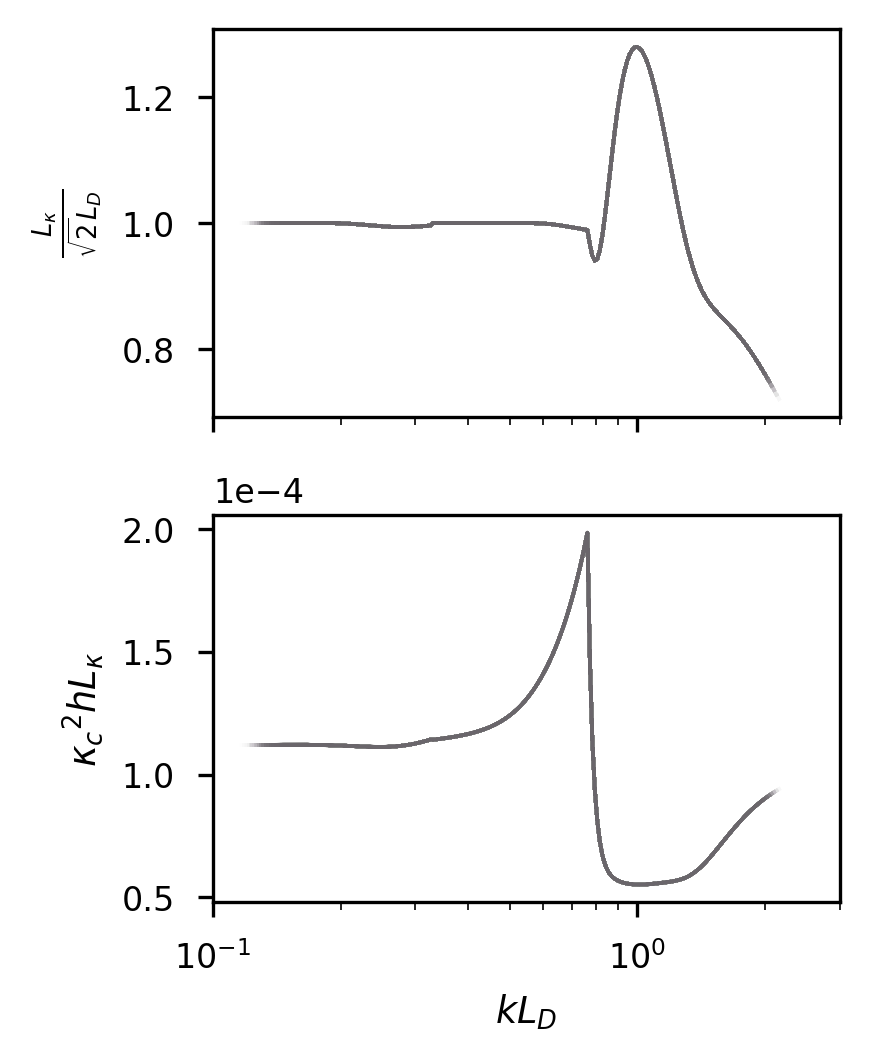

In [17]:
# hue = "energy_release_rate"
width = WIDTH_TWO_COLUMNS
height = width / GR * 2 / 1.019
lw = 1

lineplot_kwds = dict(
    c="C3",
    alpha=1 / n_samples,
    hue=hue,
    estimator=None,
    palette=[colours[3]] * n_samples,
    legend=False,
    lw=lw,
)

with plt.style.context("seaborn-v0_8-paper"), palette:
    fig, axes = plt.subplots(2, sharex=True, dpi=300, figsize=(width, height))

    ax = axes[0]
    sns.lineplot(
        ensemble_results,
        x="nondim",
        y="normalised_dis_length",
        ax=ax,
        **lineplot_kwds,
    )
    ax.set_ylabel(r"$\frac{L_{\kappa}}{\sqrt{2} L_D}$")

    ax = axes[1]
    sns.lineplot(
        ensemble_results,
        x="nondim",
        y="constant1",
        ax=ax,
        **lineplot_kwds,
    )
    ax.set_xlabel("$k L_D$")
    ax.set_ylabel(r"${\kappa_c}^2 h L_{\kappa}$")
    ax.set_xscale("log")
    ax.set_xlim(1e-1, 3)
    ax.ticklabel_format(style="sci", axis="y", scilimits=(0,0))
    
    fig.tight_layout()

    # fig.savefig("ensemble_constants.pdf", dpi=fig.dpi, bbox_inches="tight")
    
    plt.show()
    plt.close()

In [67]:
_x, _y, _r = ensemble_results.filter(
    ~pl.col("constant1").is_nan()
).group_by("nondim").agg(
    pl.col("constant1").log().mean().exp().alias("geom_mean"),
    pl.col("constant1").log().std().exp().alias("geom_std"),
).sort("nondim").to_numpy().T

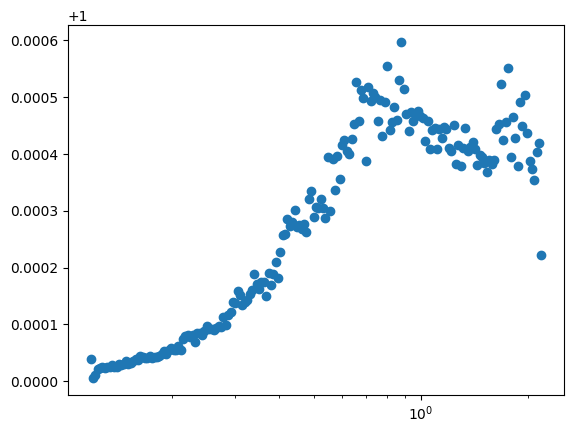

In [127]:
_x, _y, _r = ensemble_results.filter(
    ~pl.col("constant1").is_nan()
).group_by("nondim").agg(
    pl.col("constant1").log().mean().exp().alias("geom_mean"),
    pl.col("constant1").log().std().exp().alias("geom_std"),
).sort("nondim").to_numpy().T

# plt.hist(
#     _r,
#     density=True,
# )
# sns.stripplot(
#     x=_r,
# )
plt.scatter(_x, _r)
plt.xscale("log")
plt.show()
plt.close()

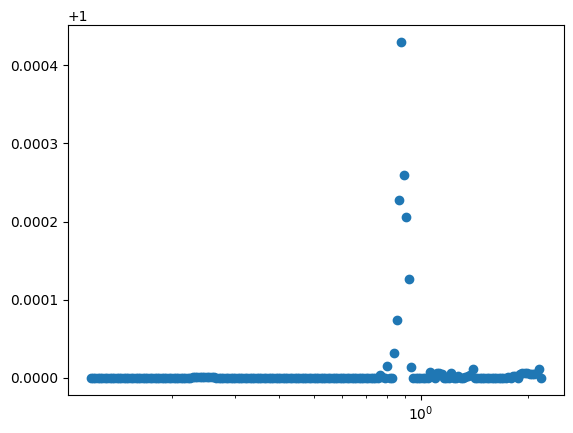

In [126]:
_x, _y, _r = ensemble_results.filter(
    ~pl.col("normalised_dis_length").is_nan()
).group_by("nondim").agg(
    pl.col("normalised_dis_length").log().mean().exp().alias("geom_mean"),
    pl.col("normalised_dis_length").log().std().exp().alias("geom_std"),
).sort("nondim").to_numpy().T

# sns.stripplot(
#     x=_r,
#     # density=True,
# )
plt.scatter(_x, _r)
plt.xscale("log")
plt.show()
plt.close()

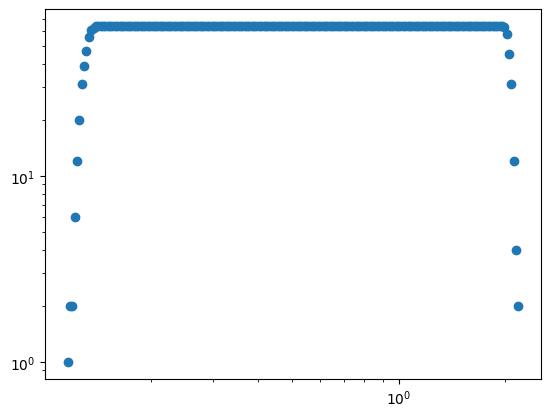

In [125]:
plt.scatter(*ensemble_results.filter(
    ~pl.col("normalised_dis_length").is_nan()
).group_by("nondim").count().sort("nondim").to_numpy().T)
plt.xscale("log")
plt.yscale("log")
plt.show()
plt.close()

In [143]:
_x, _lists = ensemble_results.filter(
    ~pl.col("constant1").is_nan()
).group_by("nondim").agg(
    pl.col("constant1")
).sort("nondim").to_numpy().T

In [148]:
nbins = sns.distributions._freedman_diaconis_bins(np.log(_list))
bins = np.geomspace(min(_list), max(_list), nbins)

In [153]:
fig, axes = plt.subplots(16, 12, figsize=(48, 36))

for ax, _nd, _list in zip(np.ravel(axes), _x, _lists):
    nbins = sns.distributions._freedman_diaconis_bins(np.log(_list))
    bins = np.geomspace(min(_list), max(_list), nbins)
    ax.hist(
        _list,
        bins,
        density=True
    )
    ax.set_xscale("log")
    ax.set_title(f"{_nd:.3e}, N={len(_list)}")

fig.tight_layout()
fig.savefig("tmp.png", dpi=fig.dpi, bbox_inches="tight")
# plt.show()
plt.close()

## Fits Baptiste

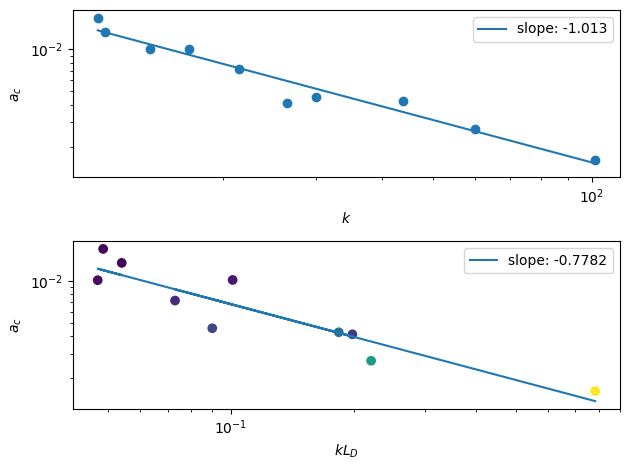

In [118]:
xx = np.copy(experimental_wavenumbers)
sk = np.argsort(xx)
xx = xx[sk]
yy = experimental_thresholds[sk]
xc = experimental_flex_lengths[sk]



fig, axes = plt.subplots(2, sharey=True)

ax = axes[0]
fit = sm.OLS(np.log(yy), sm.add_constant(np.log(xx))).fit()
ax.scatter(xx, yy)
ax.loglog(xx, np.exp(fit.fittedvalues), label=f"slope: {fit.params[1]:.4}")
ax.set_xlabel("$k$")
ax.set_ylabel("$a_c$")
ax.legend()

ax = axes[1]
fit = sm.OLS(np.log(yy), sm.add_constant(np.log(xx * xc))).fit()
ax.scatter(xx * xc, yy, c=xx)
ax.loglog(np.exp(fit.model.exog[:, 1]), np.exp(fit.fittedvalues), label=f"slope: {fit.params[1]:.4}")
ax.set_xlabel("$k L_D$")
ax.set_ylabel("$a_c$")
ax.legend()

fig.tight_layout()

plt.show()
plt.close()

[1.6131274436407095]


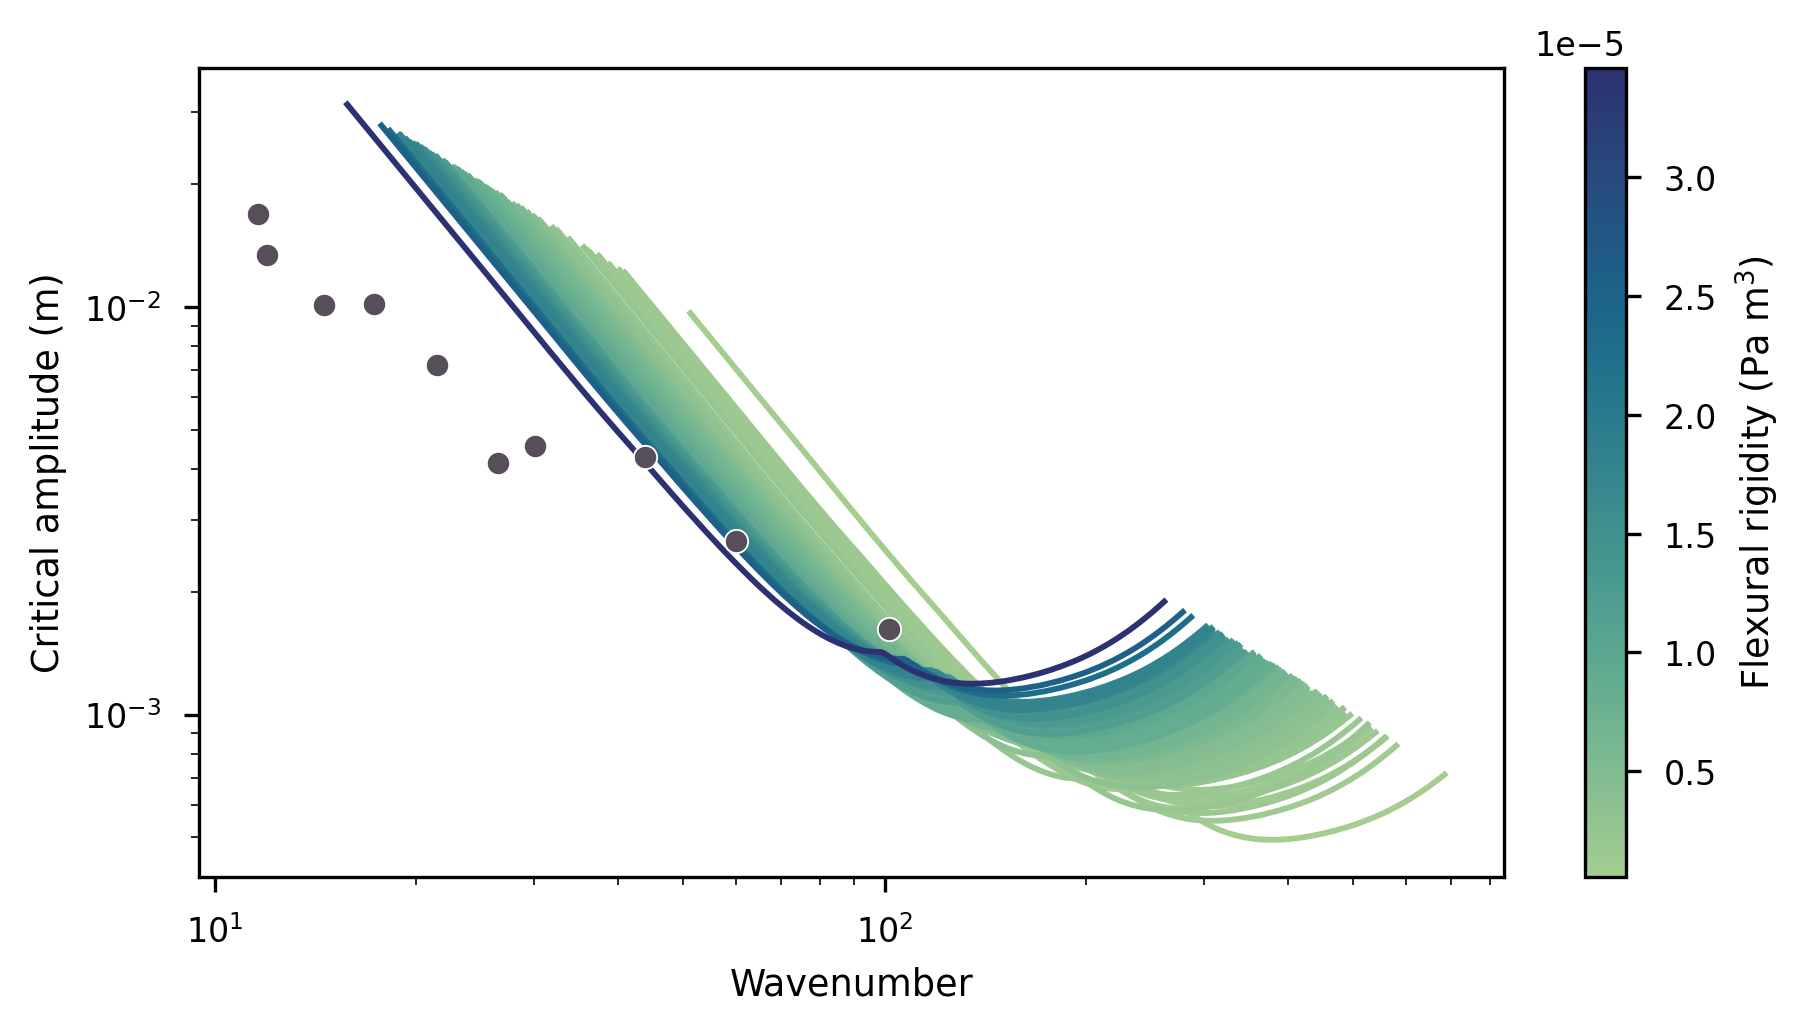

In [121]:
hue = "flexural_rigidity"
width = WIDTH_SINGLE_COLUMN
height = width / GR / 1.098

with plt.style.context("seaborn-v0_8-paper"), palette:
    fig, ax = plt.subplots(dpi=300, figsize=(width, height))
    
    sns.lineplot(
        ensemble_results,
        x="wavenumber",
        y="amplitude_threshold",
        ax=ax,
        hue=hue,
        palette="crest",
        legend="full",
    )
    sns.scatterplot(
        x=experimental_wavenumbers,
        y=experimental_thresholds,
        ax=ax,
        color="C3",
        zorder=10,
        label="Physical experiment"
    )
    ax.set_xlabel("Wavenumber")
    ax.set_ylabel("Critical amplitude (m)")
    ax.loglog()

    ax.get_legend().set_visible(False)
    
    vmin, vmax = np.sort(
        (ensemble_results.select(hue).unique().to_numpy()[:, 0])
    )[[0, -1]]
    cbar = fig.colorbar(
        mpl.cm.ScalarMappable(
            norm=mpl.colors.Normalize(
                vmin=vmin,
                vmax=vmax,
                clip=False
            ),
            cmap="crest"
        ),
        ax=ax,
        label="Flexural rigidity (Pa m$^3$)",
    )

    fig.tight_layout()
    print([ax.bbox.width / ax.bbox.height])
    
    plt.show()
    plt.close()

In [137]:
xx, yy = ensemble_results.filter(pl.col("flexural_rigidity")==flexural_rigidities.max()).select(
    "nondim", "amplitude_threshold"
).filter(~pl.col("amplitude_threshold").is_nan()).filter(pl.col("nondim") < .3).sort("nondim").to_numpy().T
fit = sm.OLS(np.log(yy), sm.add_constant(np.log(xx))).fit()
print(fit.params[1])

-1.9991807564463793


# Multi-harmonic dimensionless

In [7]:
gravity, tank_params, varnish_params = make_parameters()

varnish = Ice(**varnish_params)
tank = Ocean(**tank_params)
floating_varnish = FloatingIce.from_ice_ocean(ice=varnish, ocean=tank, gravity=gravity)
flexural_length = floating_varnish.elastic_length

max_hn = 5
dataframes = [None] * max_hn
for i, harmonic_number in enumerate(range(1, max_hn + 1)):
    if harmonic_number == 3:
        path = "results/stationnary_ensemble_comparison_nondim.npz"
    elif harmonic_number in (1, 2, 4, 5):
        path = f"results/stationnary_ensemble_comparison_nondim_hn{harmonic_number:02d}.npz"
    else:
        raise ValueError
    
    loaded = np.load(path)
    (
        nondim,
        thicknesses,
        flex_lengths,
        wavenumbers,
        curvature_thresholds,
        energy_dissipation_lengths,
    ) = (
        loaded[k] for k in (
            "nondim",
            "thicknesses",
            "flex_lengths",
            "wavenumbers",
            "curvature_thresholds",
            "energy_dissipation_lengths",
        )
    )
    n_samples = len(thicknesses)
    
    ensemble_results = pl.from_dict(
        dict(
            nondim=np.tile(nondim, n_samples),
            thickness=np.repeat(thicknesses, nondim.size),
            flexural_length=np.repeat(flex_lengths, nondim.size),
            amplitude_threshold=np.ravel(amplitude_thresholds),
            wavenumber=np.ravel(wavenumbers),
            curvature_threshold=np.ravel(curvature_thresholds),
            energy_dissipation_length=np.ravel(energy_dissipation_lengths),
            harmonic_number=np.ones(n_samples * nondim.size, dtype=int) * harmonic_number
        )
    )
    dataframes[i] = ensemble_results.filter(
        ~pl.col("curvature_threshold").is_nan()
    ).with_columns(
        pl.col("curvature_threshold").abs(),
    ).with_columns(
        (
            pl.col("curvature_threshold")**2
            * pl.col("energy_dissipation_length")
            * pl.col("thickness")
        ).alias("nondim2"),
        (pl.col("energy_dissipation_length") / (2**.5 * pl.col("flexural_length"))).alias("normalised_dis_length"),
    )
multi_harmonic_results = pl.concat(dataframes)
multi_harmonic_results.columns

['nondim',
 'thickness',
 'flexural_length',
 'amplitude_threshold',
 'wavenumber',
 'curvature_threshold',
 'energy_dissipation_length',
 'harmonic_number',
 'nondim2',
 'normalised_dis_length']

In [26]:
multi_harmonic_results.write_parquet("multi_harmonics_ensemble.parquet")

In [8]:
max_harmonic = 4
aggregated_results = (
    multi_harmonic_results
    .filter(pl.col("harmonic_number") <= max_harmonic)
    .group_by("nondim", "harmonic_number")
    .agg(
        pl.col("normalised_dis_length").mean(),
        pl.col("nondim2").mean(),
    )
)
number_of_harmonics = len(aggregated_results.get_column("harmonic_number").unique())
rough_mask = (pl.col("harmonic_number") % 2 == 0) & (pl.col("nondim2") < 1e-16)
aggregated_results.get_column("harmonic_number").unique().sort().to_list()

[1, 2, 3, 4]

## Figure

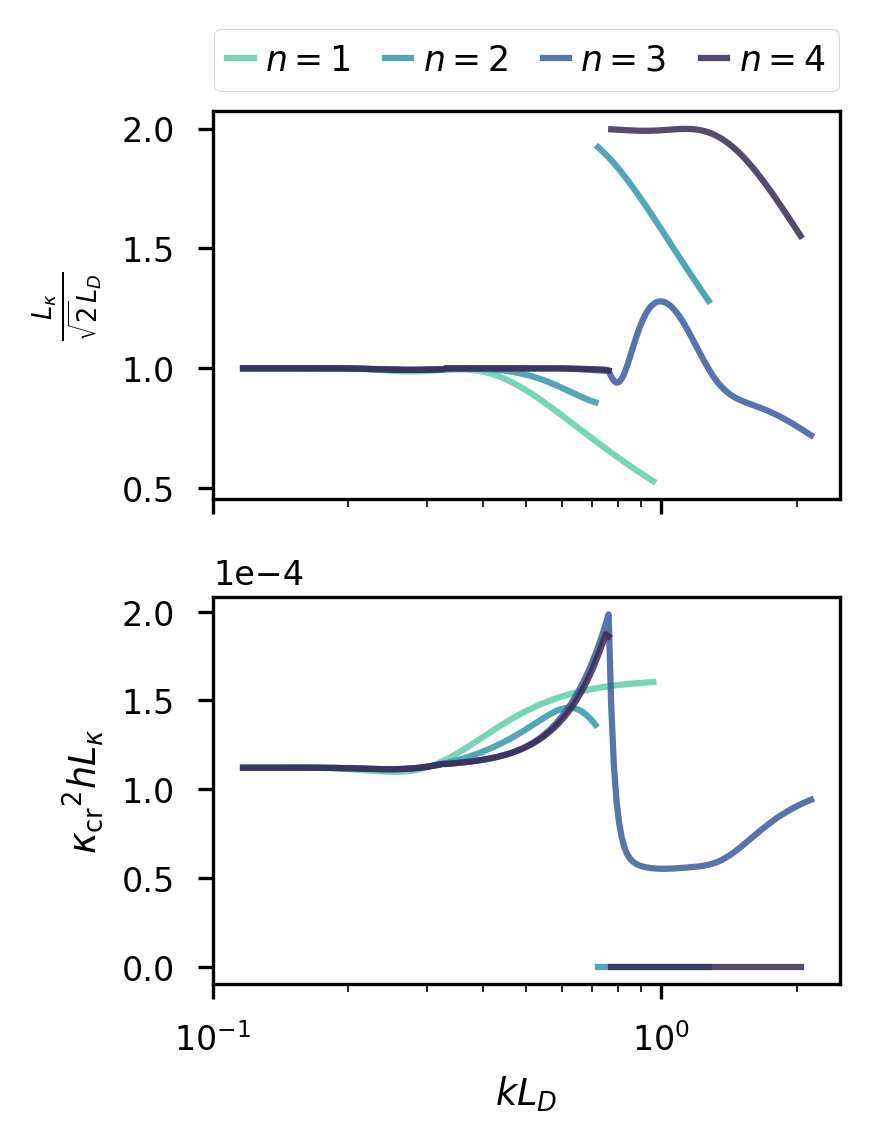

In [9]:
width = WIDTH_TWO_COLUMNS
height = width / GR * 2 / 1.019
lw = 1.5

tempo_palette = sns.color_palette("mako_r", max_harmonic)

lineplot_kwds = dict(
    alpha=.85,
    hue="harmonic_number",
    hue_order=list(range(1, max_harmonic+1)),
    palette=tempo_palette,
    lw=lw,
)

with plt.style.context("seaborn-v0_8-paper"), tempo_palette:
    fig, axes = plt.subplots(2, sharex=True, dpi=300, figsize=(width, height))

    for df in (aggregated_results.filter(~rough_mask), aggregated_results.filter(rough_mask)):
        ax = axes[0]
        sns.lineplot(
            df,
            x="nondim",
            y="normalised_dis_length",
            ax=ax,
            legend=False,
            **lineplot_kwds,
        )
    
        ax = axes[1]
        sns.lineplot(
            df,
            x="nondim",
            y="nondim2",
            ax=ax,
            **lineplot_kwds,
        )
    ax.set_xlabel("$k L_D$")
    axes[0].set_ylabel(r"$\frac{L_{\kappa}}{\sqrt{2} L_D}$")
    ax.set_ylabel(r"${\kappa_{\text{cr}}}^2 h L_{\kappa}$")
    ax.set_xscale("log")
    ax.ticklabel_format(style="sci", axis="y", scilimits=(0,0))
    ax.get_legend().set_visible(False)

    handles, labels = ax.get_legend_handles_labels()
    handles, labels = handles[:number_of_harmonics], labels[:number_of_harmonics]
    labels = [f"$n={{{_l}}}$" for _l in labels]

    fig.tight_layout()
    _bbox = axes[0].get_window_extent().transformed(fig.transFigure.inverted())
    plt.figlegend(
        handles=handles,
        labels=labels,
        ncols=4,
        handlelength=.75,
        loc="upper center",
        fontsize="small",
        bbox_to_anchor=((_bbox.x0 + _bbox.x1) / 2, 1.05),
        handletextpad=.33,
        columnspacing=1.,
    )
    ax.set_xlim(1e-1, 2.5)

    # fig.savefig("ensemble_constants.pdf", dpi=fig.dpi, bbox_inches="tight")
    
    plt.show()
    plt.close()

In [534]:
aggregated_results.group_by("harmonic_number").agg(
    pl.col("nondim").min().alias("min"),
    pl.col("nondim").max().alias("max"),
).sort("harmonic_number")

harmonic_number,min,max
i64,f64,f64
1,0.116743,0.958797
2,0.116743,1.273011
3,0.116743,2.155045
4,0.116743,2.041774
5,0.116743,1.690198


In [223]:
def fun(ks, ns):
    ls = ns * np.pi / ks
    return np.sin(ls / 2**.5) / np.sinh(ls / 2**.5) - (-1)**ns * (1 - ks**2) / (1 + ks**2)

[ 0.36452129 -2.26350607]


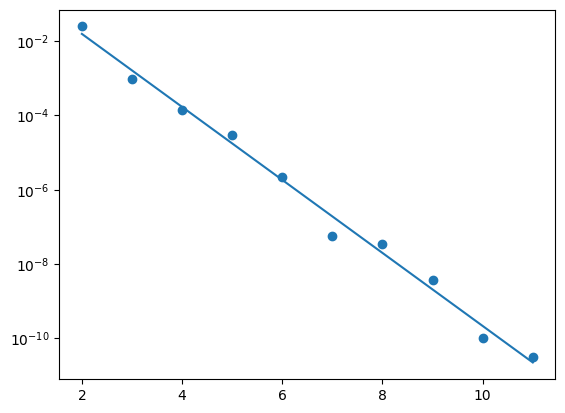

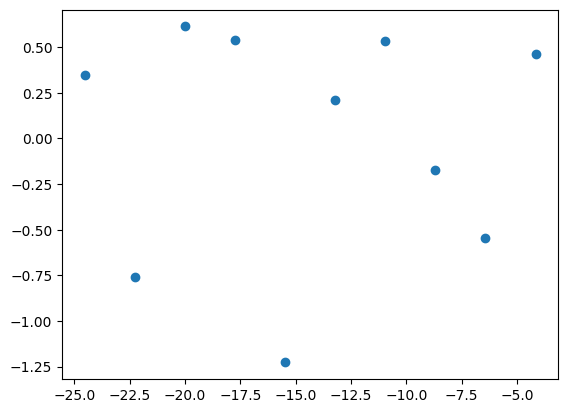

In [238]:
ns = np.arange(2, 12)
roots = np.array([optimize.root_scalar(fun, (_n,), bracket=(.8, 1.2)).root for _n in ns])
ys = np.abs(1 - roots)
fit = sm.OLS(np.log(ys), sm.add_constant(ns)).fit()
plt.scatter(ns, ys)
plt.plot(ns, np.exp(fit.fittedvalues))
print(fit.params)
# plt.loglog()
# plt.xscale("log")
plt.yscale("log")
plt.show()
plt.close()
plt.scatter(fit.fittedvalues, fit.resid)
plt.show()
plt.close()

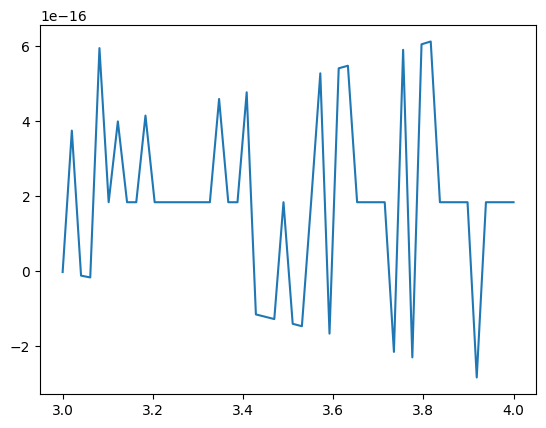

In [244]:
def fun(k, n):
    L = n * np.pi / k
    cos, sin, sqrt, cosh, sinh = np.cos, np.sin, np.sqrt, np.cosh, np.sinh
    return (
        k**2
        * (
            (-1)**n * sin(sqrt(2)*L/4)*cosh(sqrt(2)*L/4)
            + (-1)**n*cos(sqrt(2)*L/4)*sinh(sqrt(2)*L/4)
            + sin(sqrt(2)*L/4)*cosh(sqrt(2)*L/4)
            + cos(sqrt(2)*L/4)*sinh(sqrt(2)*L/4)
        ) / ((-1)**n*sinh(sqrt(2)*L/2)- sin(sqrt(2)*L/2))
        - cos(L*k/2)
    )

_n = 3
_k = np.linspace(3, 4)
plt.plot(_k, fun(_k, _n))
plt.show()
plt.close()

In [66]:
ks = np.logspace(-1, 2)
ns = np.arange(12) + 1
ls = ns[:, None] * np.pi / ks
fs = np.sin(ls / 2**.5) / np.sinh(ls / 2**.5) - (-1)**ns[:, None] * (1 - ks**2) / (1 + ks**2)

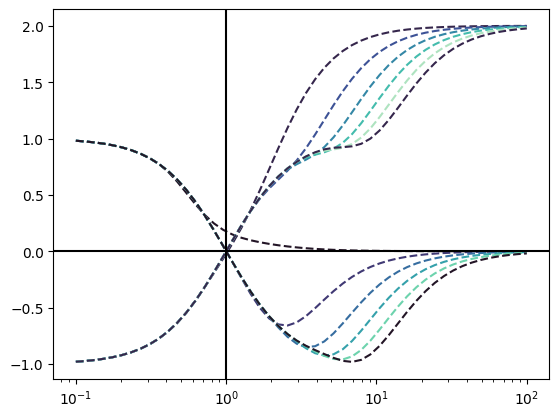

In [243]:
with sns.color_palette("mako", n_colors=len(ns)):
    plt.plot(ks, fs.T, "--")
    plt.axhline(0, c="k")
    plt.axvline(1, c="k")
    plt.xscale("log")
    plt.show()
    plt.close()